In [1]:
# import python packages to use for analysis
import numpy as np
import pandas as pd
import os
import glob
import pprint
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import seaborn as sns
from scipy.stats import norm, spearmanr
import ast
Z = norm.ppf

In [2]:
data_dir = ["./data"] # list of data folders - compatible with more than one experiment

# define empty lists that will hold the number of subjects, rejected subjects and test subjects
sub_count = [0]*len(data_dir)    # included datasets
reject_count = [0]*len(data_dir) # complete datasets, but rejected due to performance
test_count = [0]*len(data_dir)   # incomplete test datasets

complete_subs = [] # subjects that produced complete datasets

exp_n = 199 # number of experiment trials

all_data = []
# define object labels here
labels = ['bear','elephant','person','car','dog','apple','chair','plane','bird','zebra']

for e, cur_dir in enumerate(data_dir):
    file_list = glob.glob(cur_dir + "/object_recognition*.csv")
    file_list.sort()
    exp_subs = [] # list to hold the subjects in this experiment
    for file in file_list:
        # load the data
        try:
            sub_data = pd.read_csv(file)
            if "trial_type" not in sub_data:
                sub_data = pd.read_csv(file, skiprows=1)
            # in the past, some trials were duplicated in the data file, the code below takes care of that
            sub_data = sub_data[sub_data['trial_index'].apply(lambda x: str(x).isdigit())]
            sub_data = sub_data.drop_duplicates()
        except:
            print("Failed to load file {0}".format(file.split(cur_dir)[1]))
        # get id
        try:
            survey_resp = sub_data[sub_data["trial_type"]=="survey-html-form"]["responses"].values[0]
            survey_resp = survey_resp.replace(':"}',':""}')
            sub_info = ast.literal_eval(survey_resp)
        except:
            sub_info = {}
        # see if id was stored
        if 'p_id' in sub_info.keys():  
            sub_id = sub_info["p_id"]
        else:
            sub_id = "nan"
            
        # do quality control on the data
        if sub_data.shape[1] < 10:
            print(e, sub_id, "incomplete file, shape:{0}x{1}".format(sub_data.shape[0],sub_data.shape[1]))
            test_count[e] = test_count[e] + 1 # record test subject to the test_count, by adding 1 at the relevant position
            continue
        
        # now skip if this subjects data is already in the set
        if sub_id in exp_subs:
            print(e, sub_id, "duplicate participants, skipping the second file".format(num_trials))
            continue
        
        # now we can start working with the data
        images = sub_data["images"]
        left_choice = sub_data["left_choice"]
        right_choice = sub_data["right_choice"]
        rts = sub_data["rt"]
        response = sub_data["button_pressed"] # 0 = left; 1 = right;
        
        valid_loc = [ ~np.isnan(x) for x in images ]
        valid_images = [ int(x) for i, x in enumerate(images) if valid_loc[i] ] # image number
        valid_left = [ int(x) for i, x in enumerate(left_choice) if valid_loc[i] ] # which object appeared as left choice
        valid_right = [ int(x) for i, x in enumerate(right_choice) if valid_loc[i] ]
        valid_response = [ int(response[i+1]) for i, x in enumerate(response) if valid_loc[i] ] # which side did the subject choose
        choices = [ [l, r] for l, r in zip(valid_left, valid_right) ]
        valid_rt = [ float(rts[i+1]) for i, x in enumerate(rts) if valid_loc[i] ] # reaction time
        
        correct_obj_no = np.tile(range(10),[20,1])
        correct_obj_no = correct_obj_no.flatten("F") # corresponding correct object number per image
        correct_choice = [ correct_obj_no[x] for x in valid_images ]
        
        
        # final steps of quality control - do we actually have the expected number of trials?
        num_trials = sum(valid_loc) # total trials
        if num_trials < exp_n:
            print(e, sub_id, "incomplete file, on {0} trials".format(num_trials))
        
        # add participant to list of subjects for this experiment
        exp_subs.append(sub_id)
        
        # start populating sub_info dict: 
        sub_info["experiment"] = e
        sub_info["ID"] = sub_id
        
        # lets fetch all the relevant trial variables for each trial
        sub_info["im_no"] = valid_images; # all image numbers
        sub_info["target"] = correct_choice; # what was the target object number?            
        sub_info["distractor"] = [ int(np.array(i) [i != j ]) for i, j in zip(choices, correct_choice) ] # what was the distractor object number?
        sub_info["response"] = [ i [j] for i, j in zip(choices, valid_response) ] # which object with the subject choose?
        sub_info["correct"] = [i == j for i, j in zip(sub_info["response"], sub_info["target"])]
        sub_info["rt"] = valid_rt
        
        unique_objects = np.unique(correct_obj_no) # unique object numbers
        num_objects = len(unique_objects);      # how many objects are there?
        
        # generate confusion matrix
        sub_conf = np.empty((num_objects, num_objects))
        sub_conf[:] = np.nan
        conf_labels = []
        for i in unique_objects:
            for j in unique_objects:
                cur_idx = [t == i and d == j for t,d in zip(sub_info["target"], sub_info["distractor"])]
                if np.sum(cur_idx) > 0:
                    sub_conf[i,j] = 1 - np.nanmean(np.array(sub_info["correct"])[cur_idx])
                if file == file_list[-1]:
                    # labels will be the same for all subjects, so only create for the last one
                    conf_labels.append(labels[i] + "_vs_" + labels[j])
        sub_info["conf"] = sub_conf
        all_data.append(sub_info)

0 0000 duplicate participants, skipping the second file


## AVERAGE CONFUSION MATRIX AND ACCURACIES OVER SUBJECTS
You may re-run this code after removing subjects from all_conf and all_corr that more than two standard errors away from the mean. 

In [3]:
all_conf = np.array([x["conf"] for x in all_data ])
mean_conf = np.nanmean(all_conf, 0)
all_corr = np.array([np.mean(x["correct"]) for x in all_data ])
mean_corr = np.nanmean(all_corr)

/Users/kohler/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


## ACCURACIES ACROSS IMAGE PAIRS
Now we will plot the accuracies for each image pair. We will use the values from the confusion matrix, but convert them into a list. 

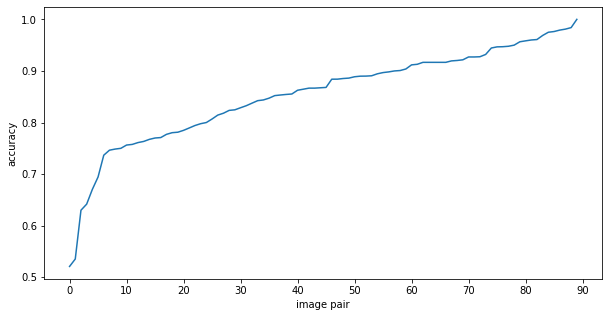

In [4]:
# get rid of nans and convert to list
conf_list = list(mean_conf.flatten())
label_list = conf_labels

# combine the two lists and convert confusion to accuracy
temp = [(1-t[0],t[1]) for t in zip(conf_list, label_list) if not np.isnan(t[0]) ]

# sort by accuracy and pull apart
conf_list, label_list = (list(t) for t in zip(*sorted(temp)))

# this was a variable I used when bebugging
test = [{t:c} for t,c in zip(conf_list, label_list)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(conf_list)
ax.set_xticks(range(0,len(label_list)+1,10))
#ax.set_xticklabels(label_list[0:10:],rotation = 45, ha="center")
plt.xlabel("image pair")
plt.ylabel("accuracy")
plt.show()

## MAKE CONFUSION MATRIX
The code below makes a confusion matrix. Each cell reflects the proportion of trials where the non-target image (distractor) was chosen for each image pair. Since the target and distractor were always different, the diagonal is colored white and marked with "NA". 

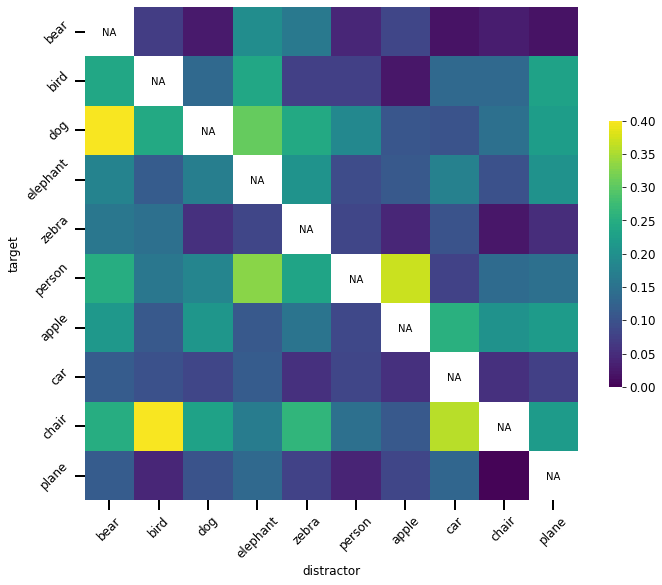

In [8]:
## convert the numpy array to a pandas dataframe variable
conf_df = pd.DataFrame(mean_conf, columns = labels, index = labels)
# reorder the labels to reveal category-specific confusion
new_labels = ['bear','bird','dog','elephant','zebra','person','apple','car','chair','plane']
# apply the new ordering to the dataframe
conf_df = conf_df.reindex(columns=new_labels, index=new_labels)
# now make a figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
# first plot a only the nan values, so they can be identified
sns.heatmap(
    np.where(conf_df.isna(), 0, np.nan),
    ax=ax,
    cbar=False,
    annot=np.full_like(conf_df, "NA", dtype=object),
    fmt="",
    annot_kws={"size": 10, "va": "center_baseline", "color": "black"},
    cmap=ListedColormap(['none']),
    linewidth=0)
# then overlay the actual values from the non-nan cells
sns.heatmap(
    conf_df, 
    ax=ax, 
    vmin=0, vmax=.4, 
    cbar=True, cbar_kws={'shrink':.4}, 
    cmap=sns.color_palette("viridis", 100), 
    square=True) 

# labels the axes
ax.set_xticklabels(new_labels, rotation = 45, ha="center")
plt.xlabel("distractor")
plt.ylabel("target")
ax.set_yticklabels(new_labels, rotation = 45, va="center")
ax.tick_params(length=10, width=2)
plt.tight_layout()